## Purpose

---

This file is for 'manually' calculating outputs so we can validate the system output.


In [1]:
from math import sin, cos, atan2, sqrt
import numpy as np
from loguru import logger
logger.remove()

In [2]:
EPSG_32633_BALATON = 32633
WGS84_GPS = 4326

In [3]:
# Rectangle corners (latitude, longitude) - roughly 30x20 meter box
from gps_coordinate.base import GPSPoint


W = 17.642
E = 17.643
S = 46.782
N = 46.783

boat_origin = GPSPoint(S-0.002, W)    # bottom-left
boat_current = boat_origin

corner_1 = GPSPoint(N, W)       # top-left
corner_2 = GPSPoint(N, E)       # top-right

corner_3 = GPSPoint(S, E)     # top-right
corner_4 = GPSPoint(S, W)     # top-left


# Ordered loop of waypoints
waypoints = [corner_1, corner_2, corner_3, corner_4]

boat_current, waypoints

(GPSPoint(lat=46.78000, lon=17.64200),
 [GPSPoint(lat=46.78300, lon=17.64200),
  GPSPoint(lat=46.78300, lon=17.64300),
  GPSPoint(lat=46.78200, lon=17.64300),
  GPSPoint(lat=46.78200, lon=17.64200)])

In [4]:
# Current heading
psi_current_deg = 90.0  # because east is 0° and north is 90°...
psi_current_rad = np.deg2rad(psi_current_deg)

psi_current_deg, psi_current_rad  # (90.0, np.float64(1.5707))

(90.0, np.float64(1.5707963267948966))

In [5]:
# Controller parameters
engine_rpm = 440  # fixed value for now
delta_t = 0.2  # or your loop interval

U = 1.1  # [m/s]
k1, k2, k3, k4 = 1.6, 19.92, 2.125, 92.1

Made using [mapcustomizer](https://www.mapcustomizer.com/#)

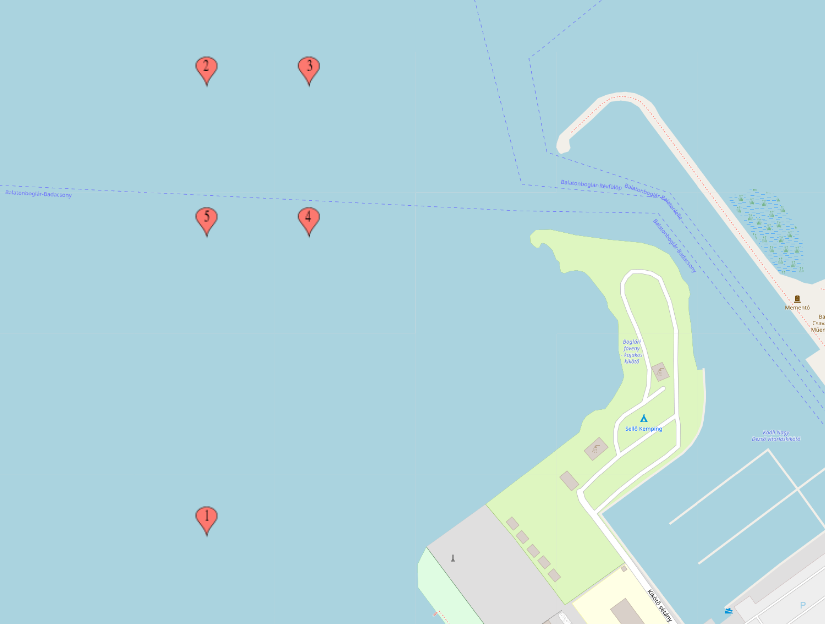


---


In [6]:
# Helper Functions + rudder controll

def heading_to_next_waypoint(current: GPSPoint, next: GPSPoint):
    """Eq. (4): Heading from point 0 to point 1"""
    x_0, y_0 = current.Xn, current.Yn
    x_1, y_1 = next.Xn, next.Yn

    dx = x_1 - x_0
    dy = y_1 - y_0

    return atan2(dy, dx)


def cross_track_error(current: GPSPoint, reference: GPSPoint, psi_k):
    x, y = current.Xn, current.Yn
    x_ref, y_ref = reference.Xn, reference.Yn
    return sin(psi_k) * (x - x_ref) - cos(psi_k) * (y - y_ref)


def control_output(e_psi, de_psi, e_y, int_e_y):
    delta_PD = k1 * e_psi + k2 * de_psi
    delta_PI = k3 * e_y + k4 * int_e_y

    print(f"delta_PD: {delta_PD}")
    print(f"delta_PI: {delta_PI}")
    return delta_PD + delta_PI


def get_rudder_angle(boat_current: GPSPoint, target: GPSPoint, psi_current_rad):
    psi_k = heading_to_next_waypoint(boat_current, target)
    # psi = np.rad2deg(psi_k)

    e_psi = psi_current_rad - psi_k

    # 2. Compute errors

    e_y = cross_track_error(boat_current, target, psi_k)
    int_e_y = 0.1 * e_y  # crude accumulated integral

    e_psi_prev = 0.0  # rate of change of heading error
    de_psi = (e_psi - e_psi_prev) / delta_t

    # 3. Final control output (rudder angle)
    rudder_angle_deg = control_output(e_psi, de_psi, e_y, int_e_y)
    rudder_angle_deg_clipped = np.clip(rudder_angle_deg, -35, 35)  # saturation, in °
    print(f"rudder_angle_deg: {rudder_angle_deg}, clipping to: {rudder_angle_deg_clipped}")

    return rudder_angle_deg_clipped, rudder_angle_deg

---


## FIRST WAYPOINT


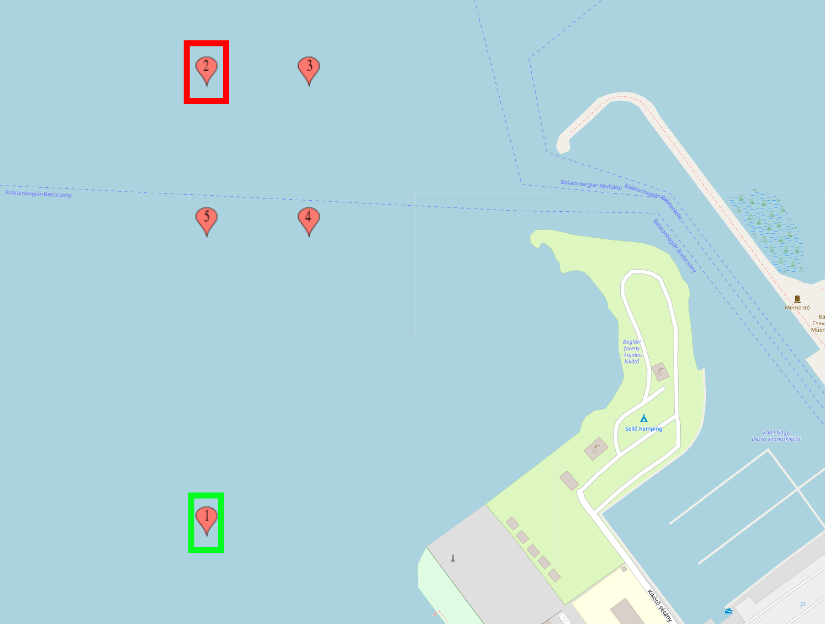


In [7]:
wp_index = 0
target = waypoints[wp_index]
psi_k = heading_to_next_waypoint(boat_current, target)
psi = np.rad2deg(psi_k)

In [8]:
print(f"Our heading relative to North is: {(psi - 90):.4f}")  # 90°is North, 0° is East, fukc EPSG

Our heading relative to North is: 1.9260


In [9]:
print(f"""
relative distances: \
dX {(target.Xn - boat_current.Xn):.3f}, \
dY {(target.Yn - boat_current.Yn):.3f}
""")


relative distances: dX -11.210, dY 333.345



In [10]:
rudder_angle_deg_clipped, rudder_angle_deg = get_rudder_angle(boat_current, target, psi_current_rad)
f"{rudder_angle_deg_clipped:.4f}°, {rudder_angle_deg:.4f}°"

delta_PD: -3.401837142507894
delta_PI: -8.054001909840735e-14
rudder_angle_deg: -3.4018371425079743, clipping to: -3.4018371425079743


'-3.4018°, -3.4018°'

## Second Waypoint


In [11]:
boat_current = waypoints[0]  # !!! UPDATES SHIP POSITION TO WP1!
psi_current_rad = np.deg2rad(rudder_angle_deg_clipped)
print(f"Current heading is {np.rad2deg(psi_current_rad):.4f}°.")

Current heading is -3.4018°.


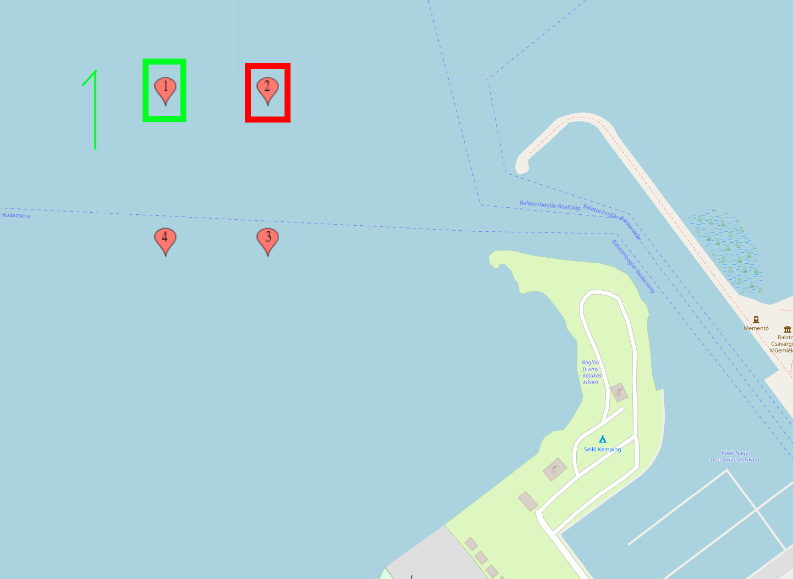


In [12]:
wp_index = 1
target = waypoints[wp_index]
psi_k = heading_to_next_waypoint(boat_current, target)
psi = np.rad2deg(psi_k)

print(f"\
      Psi is {psi:.3f} | relative: \
      dX {(target.Xn - boat_current.Xn):.3f}, \
      dY {(target.Yn - boat_current.Yn):.3f}")

      Psi is 1.926 | relative:       dX 76.328,       dY 2.567


In [13]:
rudder_angle_deg_clipped, rudder_angle_deg = get_rudder_angle(boat_current, target, psi_current_rad)
f"{rudder_angle_deg_clipped:.4f}°, {rudder_angle_deg:.4f}°"

delta_PD: -9.411138799220605
delta_PI: 0.0
rudder_angle_deg: -9.411138799220605, clipping to: -9.411138799220605


'-9.4111°, -9.4111°'